In [1]:
# importing the neccesarry libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read csv
imdb_basics = pd.read_csv('Expanded CSVs/imdb.title.basics.csv')
imdb_ratings = pd.read_csv('Expanded CSVs/imdb.title.ratings.csv')
imdb_crew = pd.read_csv('Expanded CSVs/imdb.title.crew.csv')
imdb_name = pd.read_csv('Expanded CSVs/imdb.name.basics.csv')
tn = pd.read_csv('Expanded CSVs/tn.movie_budgets.csv')
bom = pd.read_csv('Expanded CSVs/bom.movie_gross.csv')
rt = pd.read_csv('Expanded CSVs/rt.movie_info.tsv', sep='\t')

In [3]:
# fill na directors
imdb_crew['directors'] = imdb_crew['directors'].fillna('unknown')

# split the director column by the |
imdb_crew['directors'] = [director.split(',') for director in imdb_crew['directors']]

# select the first instance in the list of directors
imdb_crew['directors'] = [director[0] for director in imdb_crew['directors']]

In [4]:
#merge dataframes
imdb_title_ratings = pd.merge(imdb_basics,imdb_ratings,on="tconst")
imdb_tn = pd.merge(imdb_title_ratings, tn, left_on='primary_title', right_on='movie')
imdb_bom = pd.merge(imdb_title_ratings, bom, left_on='primary_title', right_on='title')
imdb_crew_name = pd.merge(imdb_crew, imdb_name, left_on='directors', right_on='nconst')

In [5]:
# drop unnecessary columns in crew
imdb_crew_name.drop(labels=['directors',
                            'writers', 'nconst',
                            'birth_year', 'death_year', 
                            'primary_profession', 'known_for_titles'],
                   axis=1, inplace=True)

In [6]:
# merge crew and imdb dataframes to add director names

imdb_tn = pd.merge(imdb_tn,imdb_crew_name, on='tconst')
imdb_tn.rename(columns={"primary_name": "director"}, inplace=True)

In [7]:
# sort dataframes by the number of votes, and drop the ones with least amounts
imdb_tn.sort_values(by='numvotes', axis=0, ascending=False, inplace=True)
imdb_tn.drop_duplicates(subset='primary_title', keep='first', inplace=True)
imdb_bom.sort_values(by='numvotes', axis=0, ascending=False, inplace=True)
imdb_bom.drop_duplicates(subset='primary_title', keep='first', inplace=True)

In [8]:
# fill null values
imdb_tn.production_budget.fillna(0, inplace=True)
imdb_tn.domestic_gross.fillna(0, inplace=True)
imdb_tn.fillna(0, inplace=True)
imdb_bom['domestic_gross'].fillna(0,inplace=True)
imdb_bom['foreign_gross'].fillna(0,inplace=True)

In [9]:
# change $ amounts to integer, removing $ and ,
imdb_tn['production_budget'] = imdb_tn['production_budget'].replace('[\$,]','',regex=True).astype('int64')
imdb_tn['domestic_gross'] = imdb_tn['domestic_gross'].replace('[\$,]','',regex=True).astype('int64')
imdb_tn['worldwide_gross'] = imdb_tn['worldwide_gross'].replace('[\$,]','',regex=True).astype('int64')

In [10]:
# look at the dataset before dummy variable creation

imdb_tn.sample(2)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,director
1808,tt3149360,Lucky Dog,Lucky Dog,2014,88.0,Family,5.4,49,92,"Dec 31, 2014",Lucky Dog,2000000,0,0,Michael Feifer
2657,tt4925292,Lady Bird,Lady Bird,2017,94.0,"Comedy,Drama",7.4,177677,53,"Nov 3, 2017",Lady Bird,10000000,48958273,78610769,Greta Gerwig


In [11]:
# split all of the multiple values in 'genre' and 'directors'

genres = list(set([y for x in [a.split(',') for a in imdb_tn['genres']] for y in x]))


# original way of creating dummy variables - outdated
# # iterate through series to show if 'genres' column contains genre
# def genre_finder(genre, cell):
#     if genre in cell:
#         return 1
#     return 0

# # iterate through set_of_lists and create a new column for each genre
# def column_creator(genres):
#     '''Use this to split the imdb_tn dataframe and add dummy vairables for genre'''
#     for genre in genres:
#         imdb_tn[genre] = imdb_tn['genres'].map(lambda cell: genre_finder(genre, cell))
        
# column_creator(genres)

In [12]:
# MUCH EASIER WAY TO CREATE DUMMY VARIABLES
imdb_tn = imdb_tn.join(imdb_tn.genres.str.get_dummies(','))

In [13]:
# drop unnecessary columns
imdb_tn = imdb_tn.drop(labels=['tconst', 'original_title', 'runtime_minutes', 'averagerating', 'numvotes', 'id', 'movie'], axis=1)

In [14]:
# a look after the dummy columns and dropping unnecessary columns
imdb_tn.sample(2)

,primary_title,start_year,genres,release_date,production_budget,domestic_gross,worldwide_gross,director,Action,Adventure,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
1452,X-Men: Days of Future Past,2014,"Action,Adventure,Sci-Fi","May 23, 2014",200000000,233921534,747862775,Bryan Singer,1,1,...,0,0,0,0,0,1,0,0,0,0
12,Tangled,2010,"Adventure,Animation,Comedy","Nov 24, 2010",260000000,200821936,586477240,Nathan Greno,0,1,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# create profit column (revenue - production_budget)
imdb_tn['profit'] = imdb_tn['worldwide_gross'] - imdb_tn['production_budget']

In [16]:
# create values for box_office revenue
box_office_mean = []

for genre in genres:
    box_office_mean.append(round(imdb_tn[(imdb_tn[genre]==1) & (imdb_tn['worldwide_gross']>1_000_000)].worldwide_gross.mean(),0))
    


In [17]:
# creating a dataframe with descending average revenue bye genre
genre_group_df = pd.DataFrame(list(zip(genres, box_office_mean)),
                              columns=['Genre', 'box_office_mean']).sort_values('box_office_mean',
                                                                                ascending=False)

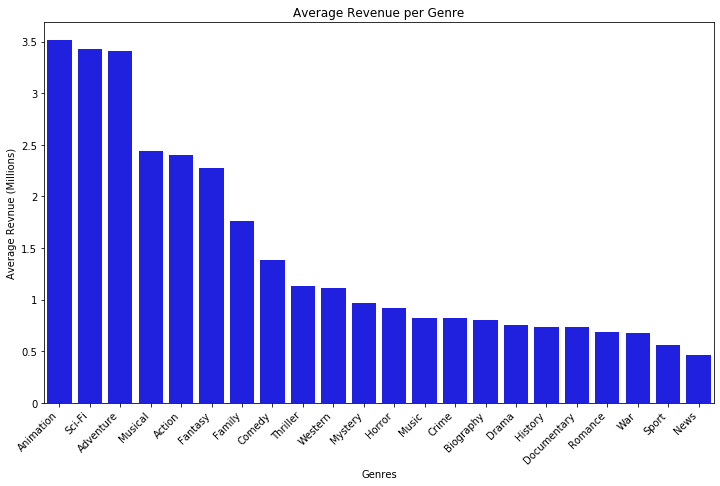

In [18]:
fig, ax = plt.subplots(figsize = (12,7))
bars = sns.barplot(x=genre_group_df['Genre'], y=genre_group_df['box_office_mean'], color='blue');

ax.set_xlabel('Genres')
ax.set_ylabel('Average Revnue (Millions)')
ax.set_title('Average Revenue per Genre')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
ax.set_yticklabels(labels=[0,.5,1,1.5,2,2.5,3,3.5]);
plt.show()

In [19]:
profit_mean = []

for genre in ['Animation', 'Adventure', 'Sci-Fi', 'Action']:
    profit_mean.append(round(imdb_tn[(imdb_tn[genre]==1) & (imdb_tn['worldwide_gross']>10_000_000)].profit.mean(),0))


In [20]:
# create subsets of the dataframes for the top three genres

scifi_imdb_tn = imdb_tn[(imdb_tn['Sci-Fi'] == 1) & (imdb_tn['profit'] > 10_000_000)]
animation_imdb_tn = imdb_tn[(imdb_tn['Animation'] == 1) & (imdb_tn['profit'] > 10_000_000)]
adv_imdb_tn = imdb_tn[(imdb_tn['Adventure'] == 1) & (imdb_tn['profit'] > 1_000_000)]

In [21]:
# create dataframes of the top movies per top three genres

scifi_top_movies = scifi_imdb_tn.groupby('primary_title').agg({'profit': 'mean', 'worldwide_gross': 'mean', 'production_budget': 'mean'}).sort_values('worldwide_gross', ascending=False)
animation_top_movies = animation_imdb_tn.groupby('primary_title').agg({'profit': 'mean', 'worldwide_gross':'mean','production_budget':'mean'}).sort_values('profit', ascending=False).head(10)
adv_top_movies = adv_imdb_tn.groupby('primary_title').agg({'profit': 'mean', 'worldwide_gross': 'mean', 'production_budget':'mean'}).sort_values('worldwide_gross', ascending=False)

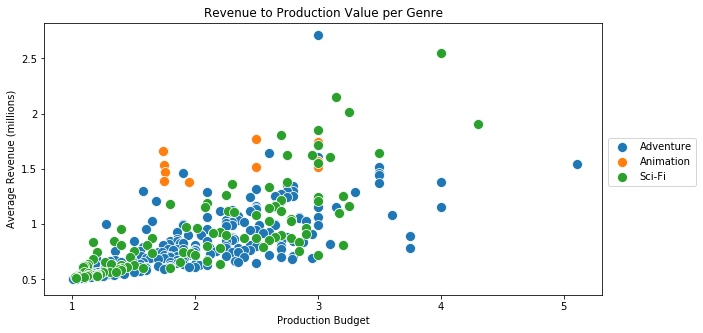

In [22]:
# create a scatter plot to show the profit vs production value

fig, ax = plt.subplots(figsize = (10,5))

# creating three different datasets for our three most profitable genres
sns.scatterplot(adv_top_movies.production_budget,
                adv_top_movies.worldwide_gross,
                s=100,
                label='Adventure',
               alpha=1)
sns.scatterplot(animation_top_movies.production_budget,
                animation_top_movies.worldwide_gross,
                s=100,
                label='Animation',
               alpha=1)
sns.scatterplot(scifi_top_movies.production_budget,
                scifi_top_movies.worldwide_gross,
                s=100,
               label='Sci-Fi', alpha=1)


plt.legend(loc=[1.01,0.4])
plt.xlabel('Production Budget')
plt.ylabel('Average Revenue (millions)')
plt.title('Revenue to Production Value per Genre');
ax.set_yticklabels(labels=[0,.5,1,1.5,2,2.5]);
ax.set_xticklabels(labels=[0,1,2,3,4,5]);
plt.show()


In [23]:
# create neccessary sci-fi dataframes

scifi_top_directors = scifi_imdb_tn.groupby('director').agg({'profit': 'mean', 'worldwide_gross': 'mean', 'production_budget': 'mean'}).sort_values('worldwide_gross', ascending=False).head(10)
scifi_directors = scifi_imdb_tn.groupby('director').agg({'profit': 'mean', 'worldwide_gross': 'mean', 'production_budget': 'mean'}).sort_values('worldwide_gross', ascending=False)
scifi_top_movies = scifi_imdb_tn.groupby('primary_title').agg({'profit': 'mean', 'worldwide_gross': 'mean', 'production_budget': 'mean'}).sort_values('worldwide_gross', ascending=False)


In [24]:
# dataframe with the top adventure movies by worldwide revenue
adv_top_movies = adv_imdb_tn.groupby('primary_title').agg({'profit': 'mean', 'worldwide_gross': 'mean', 'production_budget':'mean'}).sort_values('worldwide_gross', ascending=False)

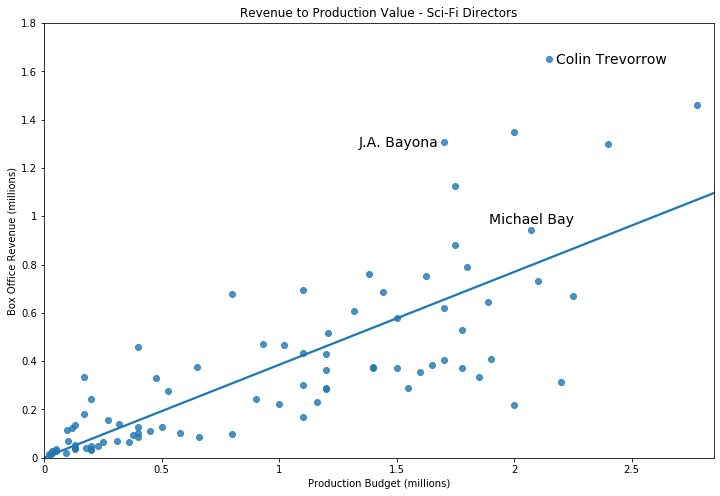

In [25]:
# create a regression plot with the directors in the sci-fi genre,
# by avg production budget and worldwide gross revenue

fig, ax2 = plt.subplots(figsize = (12,8))

# add titles to reccomended directors on the plot axes, and change the coordinates to improve legibility
for i,txt in enumerate(scifi_top_directors.index):
    if txt == 'Colin Trevorrow':
        ax2.annotate(txt, (scifi_top_directors.production_budget[i]+2900000,
                           scifi_top_directors.worldwide_gross[i]-16000000),fontsize=14)
    elif txt == 'J.A. Bayona':
        ax2.annotate(txt,
                     (scifi_top_directors.production_budget[i]-36000000,
                      scifi_top_directors.worldwide_gross[i]-17000000),fontsize=14)
    elif txt == 'Michael Bay':
        ax2.annotate(txt, (scifi_top_directors.production_budget[i]-18000000,
                           scifi_top_directors.worldwide_gross[i]+25000000),fontsize=14)

# set the plot                           
sns.regplot(scifi_directors.production_budget, scifi_directors.worldwide_gross, ci=0)

plt.xlabel('Production Budget (millions)')
plt.ylabel('Box Office Revenue (millions)')
plt.title('Revenue to Production Value - Sci-Fi Directors');
plt.xlim(0, 285_000_000)
plt.ylim(0, 1800_000_000)
ax2.set_yticklabels(labels=[0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8]);
ax2.set_xticklabels(labels=[0,.5,1,1.5,2,2.5]);
plt.show()

In [26]:
# create a unique list of the genres that also have sci-fi

scifi_sub_genres = set([y for x in [a.split(',') for a in scifi_imdb_tn['genres']] for y in x if y!= 'Sci-Fi'])

# create a list of avg profit by sci-fi sub genres

scifi_sub_genre_profit = []
for genre in scifi_sub_genres:
    scifi_sub_genre_profit.append(round(scifi_imdb_tn[(scifi_imdb_tn[genre]==1) & (scifi_imdb_tn['worldwide_gross']>10_000_000)].worldwide_gross.mean(),0))

In [27]:
# create a dataframe containing unique sci-fi sub genres
# and profits, descending by profit

scifi_set_of_lists_df = \
    pd.DataFrame(zip(scifi_sub_genres,
                     scifi_sub_genre_profit),
                 columns=['Genre','scifi_sub_genre_profit']).\
                 sort_values('scifi_sub_genre_profit',
                             ascending=False)

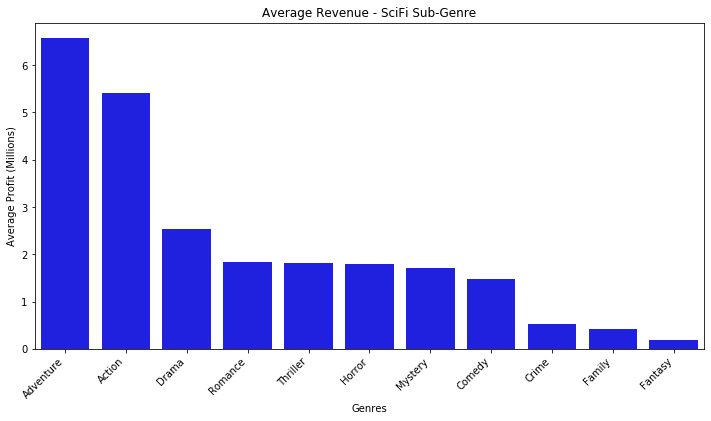

In [28]:
# create box plot with descending profits and genre

fig, ax = plt.subplots(figsize = (12,6))
sns.barplot(x=scifi_set_of_lists_df['Genre'],
            y=scifi_set_of_lists_df['scifi_sub_genre_profit'],
           color='blue');

ax.set_xlabel('Genres')
ax.set_ylabel('Average Profit (Millions)')
ax.set_title('Average Revenue - SciFi Sub-Genre')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
ax.set_yticklabels(labels=[0,1,2,3,4,5,6]);